## Case Study 1940s
In this document, we illustrate how the high melt members in the 1940s differed from the ensemble mean

In [1]:
#%%IMPORTING
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
import datetime
import matplotlib.colors as colors
divnorm = colors.TwoSlopeNorm(vcenter=0)
plt.rcParams.update({'font.size': 18})
from functions.loading_and_processing_data import loadMITgcmData,loadTimeSeriesData, detrend_and_average_MITgcmData#, read_all_data
from functions.composite_maps import createCompositeMap, createVelocityCompositeMap, defineEvents, findEvents

#### Read the data

In [2]:
%%capture
#Read time series
forcing=loadTimeSeriesData(filename='timeseries_forcing', members='all', kind='old')
forcing['time']=forcing.indexes['time'].to_datetimeindex()
vwind=loadTimeSeriesData(filename='timeseries_vwind', members='all', kind='timeseries')
vwind['time']=vwind.indexes['time'].to_datetimeindex()
full=loadTimeSeriesData(filename='timeseries_final', members='all', kind='old')
full['time']=full.indexes['time'].to_datetimeindex()
salt=loadTimeSeriesData(filename='timeseries_salt_0to200', members='all', kind='timeseries')
salt['time']=salt.indexes['time'].to_datetimeindex()
salt2=loadTimeSeriesData(filename='timeseries_salt', members='all', kind='timeseries')
salt2['time']=salt2.indexes['time'].to_datetimeindex()

salt=salt.sortby('time')
salt2=salt2.sortby('time')
vwind=vwind.sortby('time')

melt=full['dotson_to_cosgrove_massloss']

In [3]:
%%capture
#Read separate Indices
PITE=xr.open_dataarray('../02_data/indices/ADVy_TH_PITE.nc')
PITE['time']=PITE.indexes['time'].to_datetimeindex()

U115=xr.open_dataarray('../02_data/indices/undercurrent_W115.nc')
U115['time']=U115.indexes['time'].to_datetimeindex()

daU115=xr.open_dataarray('../02_data/indices/undercurrent_depth_averaged_W115.nc')
daU115['time']=daU115.indexes['time'].to_datetimeindex()

#Clumsy!
baroU115=U115-daU115

In [4]:
#Compute cumulative winds
cumul_vwind=detrend_and_average_MITgcmData(vwind, var='inner_amundsen_shelf_vwind_avg', window=1)
cumul_uwind=detrend_and_average_MITgcmData(full, var='amundsen_shelf_break_uwind_avg', window=1)
cumul_vwind=cumul_vwind.cumsum(dim='time')
cumul_uwind=cumul_uwind.cumsum(dim='time')

#Compute sea ice forcing
seaice=forcing['amundsen_shelf_seaice_freeze']+forcing['amundsen_shelf_seaice_melt']
cumul_seaice=detrend_and_average_MITgcmData(seaice.to_dataset(name='seaice'), var='seaice', window=1)
cumul_seaice=cumul_seaice.cumsum(dim='time')

#### Detrend all the time series

In [5]:
vwind_dt=detrend_and_average_MITgcmData(vwind, var='inner_amundsen_shelf_vwind_avg', window=1)
uwind_dt=detrend_and_average_MITgcmData(full, var='amundsen_shelf_break_uwind_avg', window=1)
melt_dt=detrend_and_average_MITgcmData(full, var='dotson_to_cosgrove_massloss', window=1)

cumul_vwind_dt=detrend_and_average_MITgcmData(cumul_vwind.to_dataset(name='inner_amundsen_shelf_vwind_avg'), var='inner_amundsen_shelf_vwind_avg', window=1)
cumul_uwind_dt=detrend_and_average_MITgcmData(cumul_uwind.to_dataset(name='amundsen_shelf_break_uwind_avg'), var='amundsen_shelf_break_uwind_avg', window=1)
cumul_seaice_dt=detrend_and_average_MITgcmData(cumul_seaice.to_dataset(name='seaice'), var='seaice', window=1)

seaice_dt=detrend_and_average_MITgcmData(seaice.to_dataset(name='seaice'), var='seaice', window=1)
salt_dt=detrend_and_average_MITgcmData(salt, var='amundsen_shelf_salt_btw_0_200m', window=1)   
salt2_dt=detrend_and_average_MITgcmData(salt2, var='amundsen_shelf_salt_below_0m', window=1)                                         
U115_dt=detrend_and_average_MITgcmData(U115.to_dataset(name='UVEL'), var='UVEL', window=1)
PITE_dt=detrend_and_average_MITgcmData(PITE.to_dataset(name='PITE'), var='PITE', window=1)
                                        
daU115_dt=detrend_and_average_MITgcmData(daU115.to_dataset(name='UVEL'), var='UVEL', window=1)
baroU115_dt=detrend_and_average_MITgcmData(baroU115.to_dataset(name='UVEL'), var='UVEL', window=1)

#### Create a function for showing the timeseries

In [6]:
def plot_timeseries(data, ax, window=60, handpicked=None, years=[1920,2013], show40s=True, show90s=False,
                   colors=['grey','black','blue','red'], show=[True,True,True,True], label=''):
    '''
    data (xr.Dataarray): data to be plotted
    ax (matplotlib axis): axis to plot on
    handpicked (None or list): which members to highlight
    years (list with 2 ints): xlims in years
    show40s (Boolean): should we highlight the 1940s
    show90s (Boolean): should we highlight the 1990s
    colors (list (lengtj=4)): colors to use in the plot
                              index 0: normal members 
                              index 1: ensemble mean
                              index 2: selected members
                              index 3: selected member mean
    show (list (length=4)): whether to show certain lines:
                              index 0: normal members 
                              index 1: ensemble mean
                              index 2: selected members
                              index 3: selected member mean
    label (str): label for y axis
    '''
    #Shown all members
    for i in range(20):
        if show[0]==True:
            if i==0:
                data.sel(ens=i,
                time=slice(str(years[0]), str(years[-1]))
                        ).rolling(time=window, center=True).mean().plot(c=colors[0], 
                        linewidth=0.8,  label='Member')
            else:
                data.sel(ens=i,
                time=slice(str(years[0]), str(years[-1]))
                        ).rolling(time=window, center=True).mean().plot(c=colors[0], 
                        linewidth=0.8)
    
    #Shown selected members
    if type(handpicked)!=type(None):
        if show[2]==True:
            for j, i in enumerate(handpicked):
                if j==0:
                    data.sel(ens=i,
                    time=slice(str(years[0]), str(years[-1]))
                            ).rolling(time=window, center=True).mean().plot(c=colors[2], 
                            linewidth=2,  label='Selected Member', ls='-.')
                else:
                    data.sel(ens=i,
                    time=slice(str(years[0]), str(years[-1]))
                            ).rolling(time=window, center=True).mean().plot(c=colors[2], 
                            linewidth=2, ls='-.')
        #Show selected ensemble mean
        if show[3]==True:
            data.sel(ens=handpicked).mean(dim='ens').sel(
                time=slice(str(years[0]), str(years[-1]))
                        ).rolling(time=window, center=True).mean().plot(c=colors[3], 
                       linewidth=2.2, label='Mean of Selected Members', ls='--')
    #Show ensemble mean
    if show[1]==True:
        data.mean(dim='ens').sel(
                time=slice(str(years[0]), str(years[-1]))
                        ).rolling(time=window, center=True).mean().plot(c=colors[1], 
                        linewidth=2.2, label='Ensemble Mean')
    plt.ylabel(label)
    #Show 1940s or 1990s in shaded area
    if show40s==True:
        ax.axvspan(data.sel(time='1939-09').time.values[0], 
                   data.sel(time='1942-03').time.values[0], color='red', alpha=0.3, label='1940s ENSO')
    if show90s==True:
        ax.axvspan(data.sel(time='1993').time.values[0], 
                   data.sel(time='1994').time.values[0], color='red', alpha=0.3, label='1993 and 1994')

    
    plt.grid()
    plt.legend(loc='lower right', fontsize=15)
    return ax




## Results
#### First, how to select high melt members?

In [7]:
#Option 1: Use rise in absolute melt between 1938-1939 and 1940-1941
a=melt.sel(time=slice('1940', '1941')).mean(dim='time')\
-melt.sel(time=slice('1938', '1939')).mean(dim='time')

hp=np.asarray(a.ens.sortby(a)[-5:])
hp

array([16,  2, 13,  5,  9])

Text(0.5, 1.0, 'Ice Shelf Basal Mass Loss (Dotson to Cosgrove)')

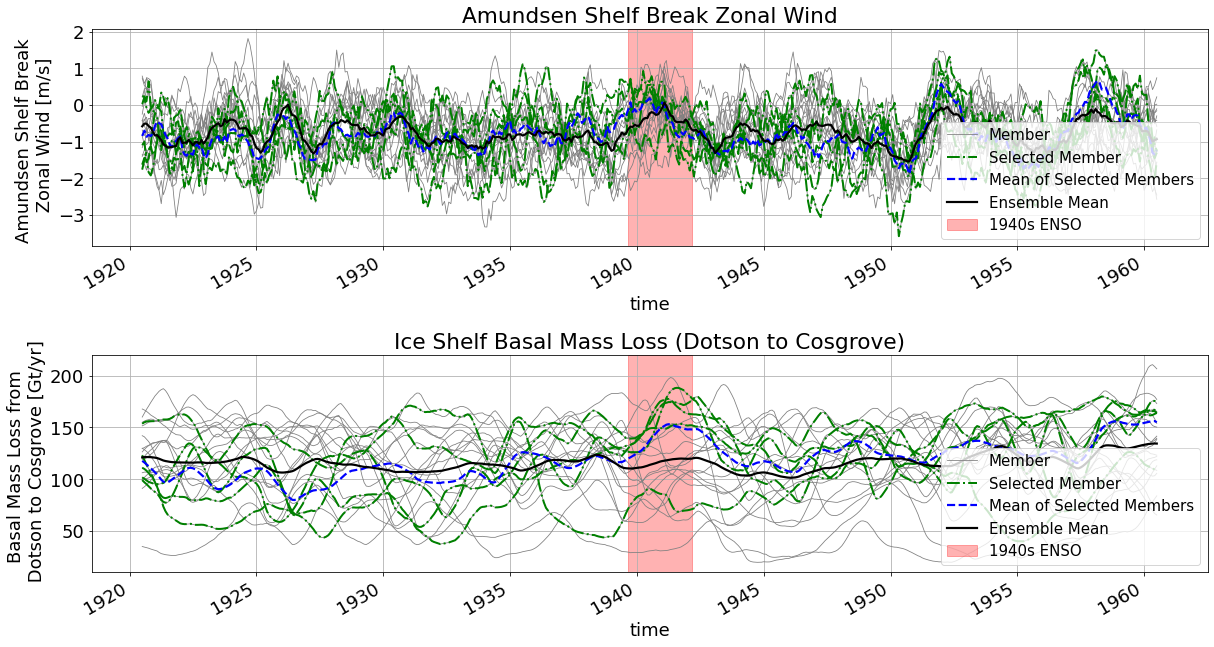

In [8]:
fig=plt.figure(plt.figure(figsize=(20,10)))
ax=plt.subplot(2,1,1)
plot_timeseries(data=full['amundsen_shelf_break_uwind_avg'], ax=ax, 
                window=12, handpicked=hp, years=[1920,1960], show40s=True,
                colors=['grey','black','green','blue'], 
                label='Amundsen Shelf Break \n Zonal Wind [m/s]')
plt.title('Amundsen Shelf Break Zonal Wind')

ax=plt.subplot(2,1,2)
plot_timeseries(data=full['dotson_to_cosgrove_massloss'], ax=ax, 
                window=12, handpicked=hp, years=[1920,1960], show40s=True,
                colors=['grey','black','green','blue'], 
                label='Basal Mass Loss from \n Dotson to Cosgrove [Gt/yr]')
plt.subplots_adjust(hspace=0.5)
plt.title('Ice Shelf Basal Mass Loss (Dotson to Cosgrove)')

In [9]:
#Option 2: Use rise in melt anomaly between 1938-1939 and 1940-1941
a=melt_dt.sel(time=slice('1940', '1941')).mean(dim='time')\
  -melt_dt.sel(time=slice('1938', '1939')).mean(dim='time')

hp=np.asarray(a.ens.sortby(a)[-5:])
hp

array([17,  2, 13,  5,  9])

Text(0.5, 1.0, 'Ice Shelf Basal Mass Loss (Dotson to Cosgrove)')

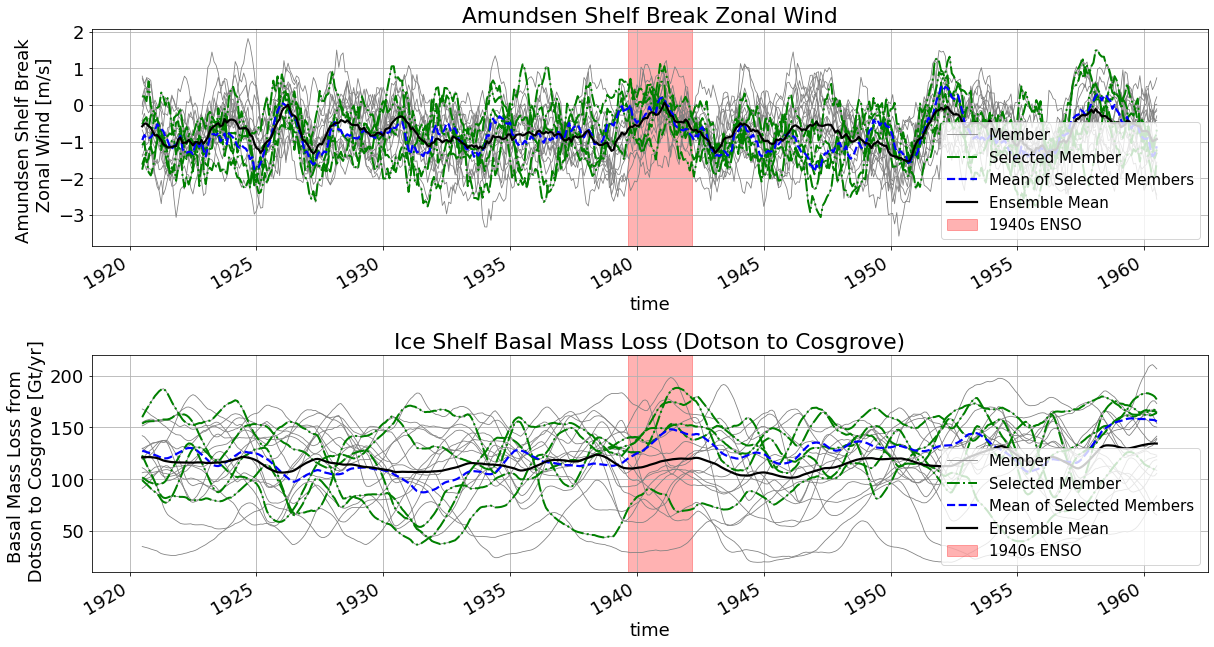

In [10]:
fig=plt.figure(plt.figure(figsize=(20,10)))
ax=plt.subplot(2,1,1)
plot_timeseries(data=full['amundsen_shelf_break_uwind_avg'], ax=ax, 
                window=12, handpicked=hp, years=[1920,1960], show40s=True,
                colors=['grey','black','green','blue'], 
                label='Amundsen Shelf Break \n Zonal Wind [m/s]')
plt.title('Amundsen Shelf Break Zonal Wind')

ax=plt.subplot(2,1,2)
plot_timeseries(data=full['dotson_to_cosgrove_massloss'], ax=ax, 
                window=12, handpicked=hp, years=[1920,1960], show40s=True,
                colors=['grey','black','green','blue'], 
                label='Basal Mass Loss from \n Dotson to Cosgrove [Gt/yr]')
plt.subplots_adjust(hspace=0.5)
plt.title('Ice Shelf Basal Mass Loss (Dotson to Cosgrove)')

In [11]:
#Option 3: Use melt anomaly 1940-1941
a=melt_dt.sel(time=slice('1940', '1941')).mean(dim='time')

hp=np.asarray(a.ens.sortby(a)[-5:])
hp

array([ 9,  2,  7, 16,  5])

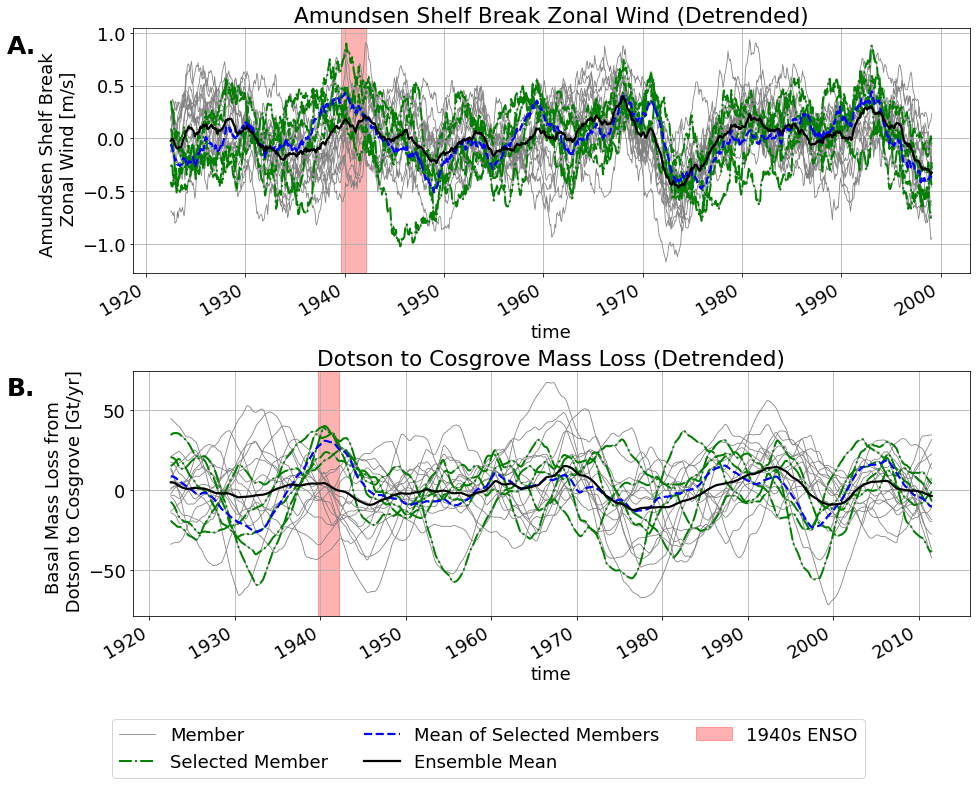

In [12]:
fig=plt.figure(plt.figure(figsize=(15,12)))
ax=plt.subplot(2,1,1)
plot_timeseries(data=full['amundsen_shelf_break_uwind_avg']-full['amundsen_shelf_break_uwind_avg']\
                .rolling(time=25*12, center=True).mean(), ax=ax, 
                window=60, handpicked=hp, years=[1920,2013], show40s=True,
                colors=['grey','black','green','blue'], 
                label='Amundsen Shelf Break \n Zonal Wind [m/s]')
plt.title('Amundsen Shelf Break Zonal Wind (Detrended)')
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()

ax=plt.subplot(2,1,2)
plot_timeseries(data=melt_dt, ax=ax, 
                window=60, handpicked=hp, years=[1920,2013], show40s=True,
                colors=['grey','black','green','blue'], 
                label='Basal Mass Loss from \n Dotson to Cosgrove [Gt/yr]')
plt.subplots_adjust(hspace=0.4, bottom=0.2)
plt.title('Dotson to Cosgrove Mass Loss (Detrended)')
ax.get_legend().remove()
#plt.suptitle('Wind and Melt through Time through Time (Detrended)')
window=60
fig.legend(handles, labels, loc='lower center', ncol=3)

import string
for n, ax in enumerate(fig.axes):
        ax.text(-0.15, 0.9, string.ascii_uppercase[n]+'.', transform=ax.transAxes, 
            size=25, weight='bold')
fig.savefig('../03_output/timeseries/selected_members_timeseries_{}months_dt.png'.format(str(window)))

In [13]:
#Option 4:  Use absolute melt in 1940-1941
a=melt.sel(time=slice('1940', '1941')).mean(dim='time')
hp=np.asarray(a.ens.sortby(a)[-5:])
hp

array([ 2,  5,  9, 16,  7])

Text(0.5, 1.0, 'Ice Shelf Basal Mass Loss (Dotson to Cosgrove)')

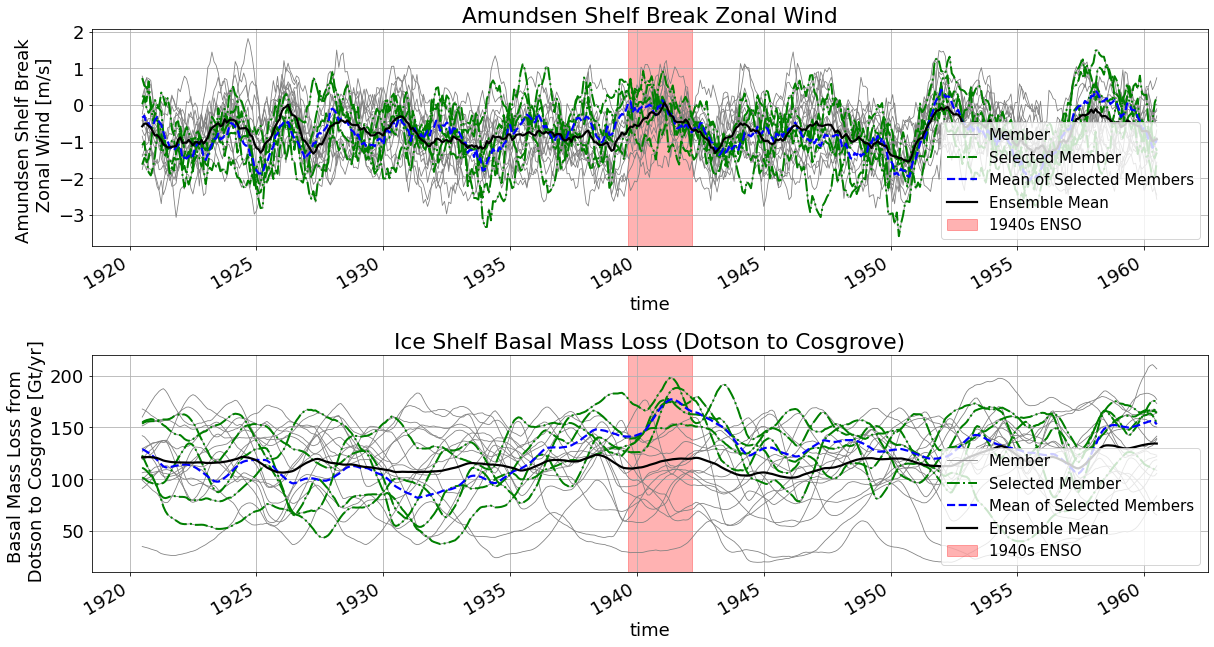

In [14]:
fig=plt.figure(plt.figure(figsize=(20,10)))
ax=plt.subplot(2,1,1)
plot_timeseries(data=full['amundsen_shelf_break_uwind_avg'], ax=ax, 
                window=12, handpicked=hp, years=[1920,1960], show40s=True,
                colors=['grey','black','green','blue'], 
                label='Amundsen Shelf Break \n Zonal Wind [m/s]')
plt.title('Amundsen Shelf Break Zonal Wind')

ax=plt.subplot(2,1,2)
plot_timeseries(data=full['dotson_to_cosgrove_massloss'], ax=ax, 
                window=12, handpicked=hp, years=[1920,1960], show40s=True,
                colors=['grey','black','green','blue'], 
                label='Basal Mass Loss from \n Dotson to Cosgrove [Gt/yr]')
plt.subplots_adjust(hspace=0.5)
plt.title('Ice Shelf Basal Mass Loss (Dotson to Cosgrove)')

#### It is chosen to use option 3, the melt anomaly in 1940-1941
#### Now: how do high melt members differ for other variables?

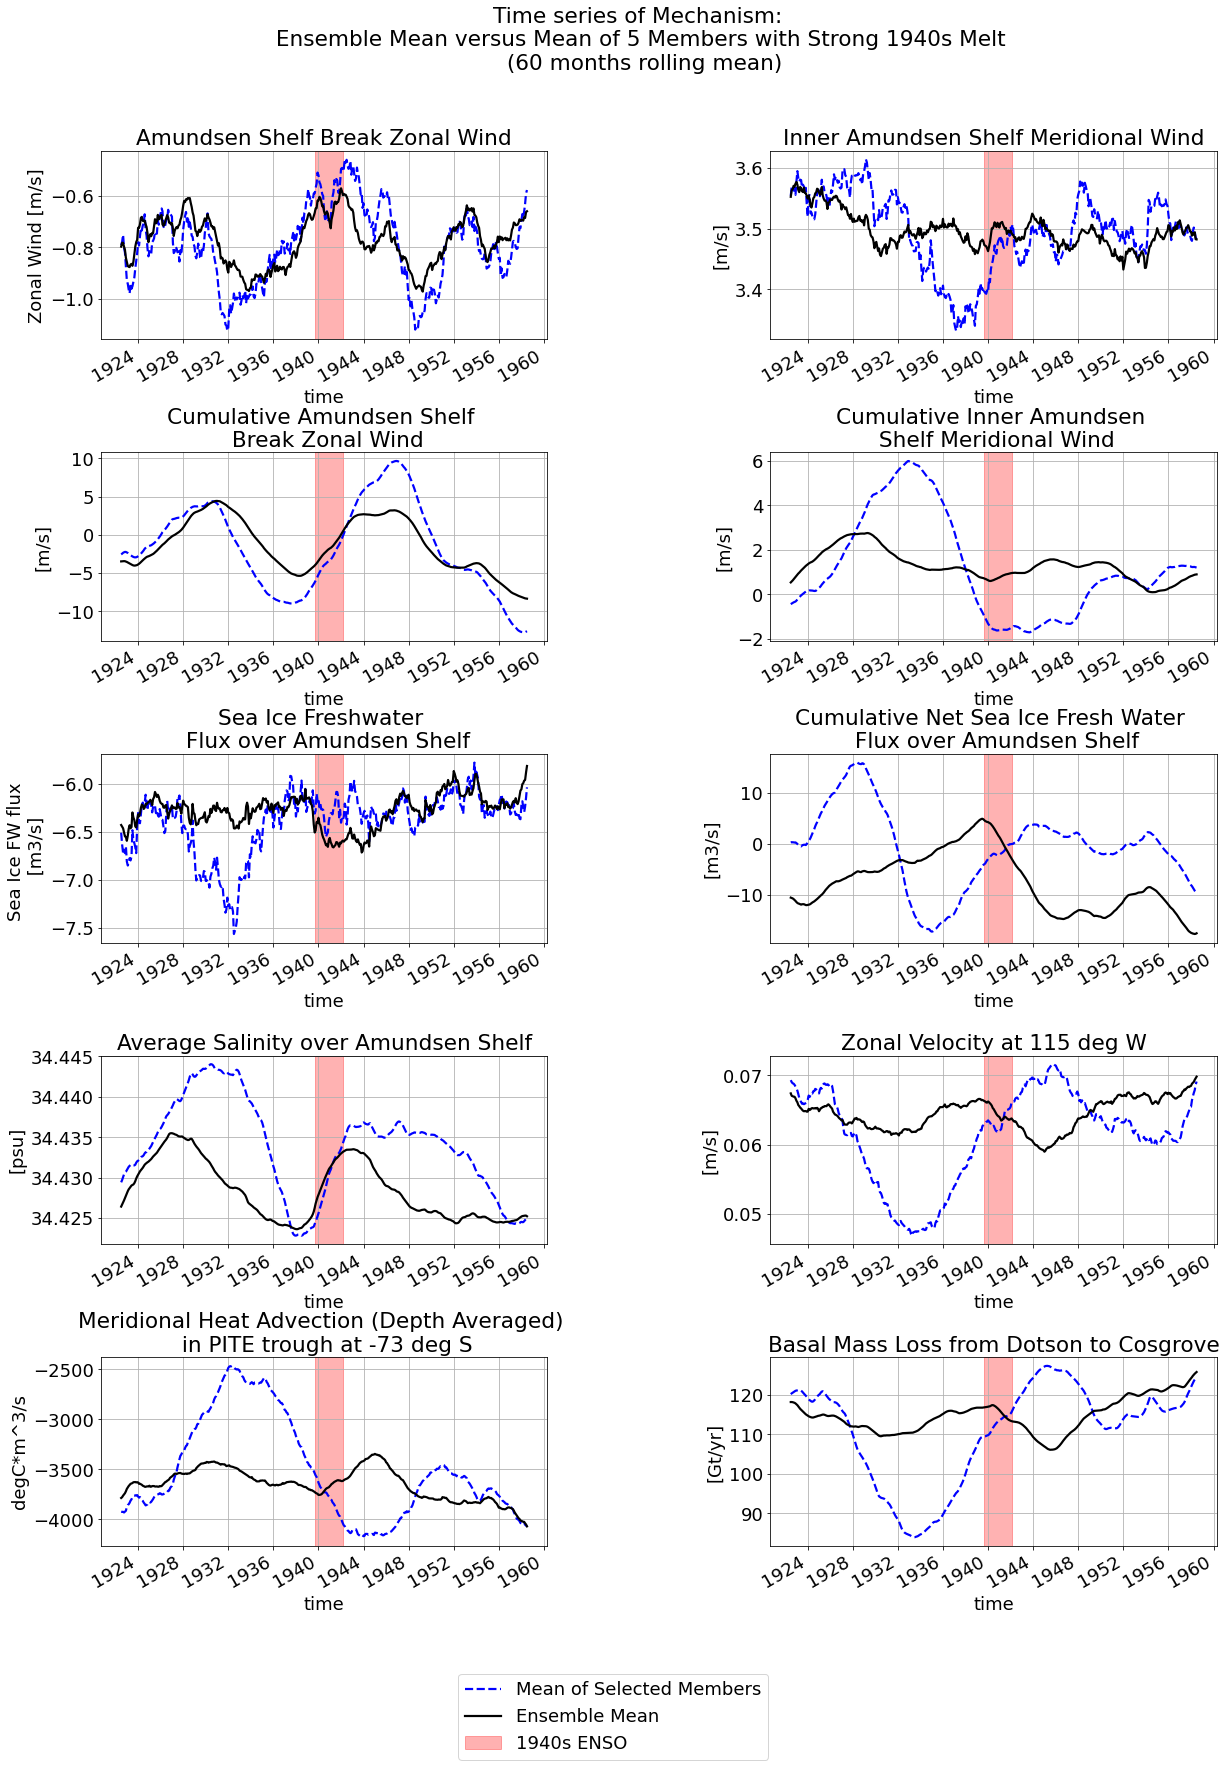

In [15]:
#What happens during strong 1940s?
#In this plot, we show data that is NOT detrended.

window=60 #Time window for rolling mean

#Which way to select high melt members?
#Option1
# a=melt.sel(time=slice('1940', '1941')).mean(dim='time')\
# -melt.sel(time=slice('1938', '1939')).mean(dim='time')
# handpicked=np.asarray(a.ens.sortby(a)[-5:])

# #Option2
# a=melt_dt.sel(time=slice('1940', '1941')).mean(dim='time')\
# -melt_dt.sel(time=slice('1938', '1939')).mean(dim='time')
# handpicked=np.asarray(a.ens.sortby(a)[-5:])

# #Option3
a=melt_dt.sel(time=slice('1945', '1946')).mean(dim='time')
handpicked=np.asarray(a.ens.sortby(a)[-5:])

# #Option4
# a=melt.sel(time=slice('1940', '1941')).mean(dim='time')
# handpicked=np.asarray(a.ens.sortby(a)[-5:])


fig=plt.figure(plt.figure(figsize=(20,25)))
fig.suptitle('Time series of Mechanism: \n Ensemble Mean versus Mean of 5 Members with Strong 1940s Melt \n ({} months rolling mean)'.format(str(window)))
ax=plt.subplot(5,2,1)
plot_timeseries(data=full['amundsen_shelf_break_uwind_avg'], ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='Zonal Wind [m/s]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Amundsen Shelf Break Zonal Wind')

ax=plt.subplot(5,2,2)
plot_timeseries(data=vwind['inner_amundsen_shelf_vwind_avg'], ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[m/s]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Inner Amundsen Shelf Meridional Wind')

ax=plt.subplot(5,2,3)
plot_timeseries(data=cumul_uwind, ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[m/s]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Cumulative Amundsen Shelf \n Break Zonal Wind')

ax=plt.subplot(5,2,4)
plot_timeseries(data=cumul_vwind, ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[m/s]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Cumulative Inner Amundsen \n Shelf Meridional Wind')

ax=plt.subplot(5,2,5)
plot_timeseries(data=forcing['amundsen_shelf_seaice_freeze']+forcing['amundsen_shelf_seaice_melt'], ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='Sea Ice FW flux \n [m3/s]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Sea Ice Freshwater \n Flux over Amundsen Shelf')

ax=plt.subplot(5,2,6)
plot_timeseries(data=cumul_seaice, ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[m3/s]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Cumulative Net Sea Ice Fresh Water \n Flux over Amundsen Shelf')

ax=plt.subplot(5,2,7)
plot_timeseries(data=salt2['amundsen_shelf_salt_below_0m'], ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[psu]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Average Salinity over Amundsen Shelf')

ax=plt.subplot(5,2,8)
plot_timeseries(data=U115, ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[m/s]', show=[False, True, False, True])
ax.set_title('Zonal Velocity at 115 deg W')
ax.get_legend().remove()

ax=plt.subplot(5,2,9)
plot_timeseries(data=PITE, ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='degC*m^3/s', show=[False, True, False, True])
ax.set_title('Meridional Heat Advection (Depth Averaged) \n in PITE trough at -73 deg S')
ax.get_legend().remove()

ax=plt.subplot(5,2,10)
plot_timeseries(data=full['dotson_to_cosgrove_massloss'], ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[Gt/yr]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Basal Mass Loss from Dotson to Cosgrove')

fig.subplots_adjust(hspace=0.6, wspace=0.5, top=0.9)
fig.legend(['Mean of Selected Members', 'Ensemble Mean', '1940s ENSO'], loc='lower center')

#fig.savefig('../03_output/timeseries/Mechanism_1940s_{}months_zoomed.png'.format(str(window)))

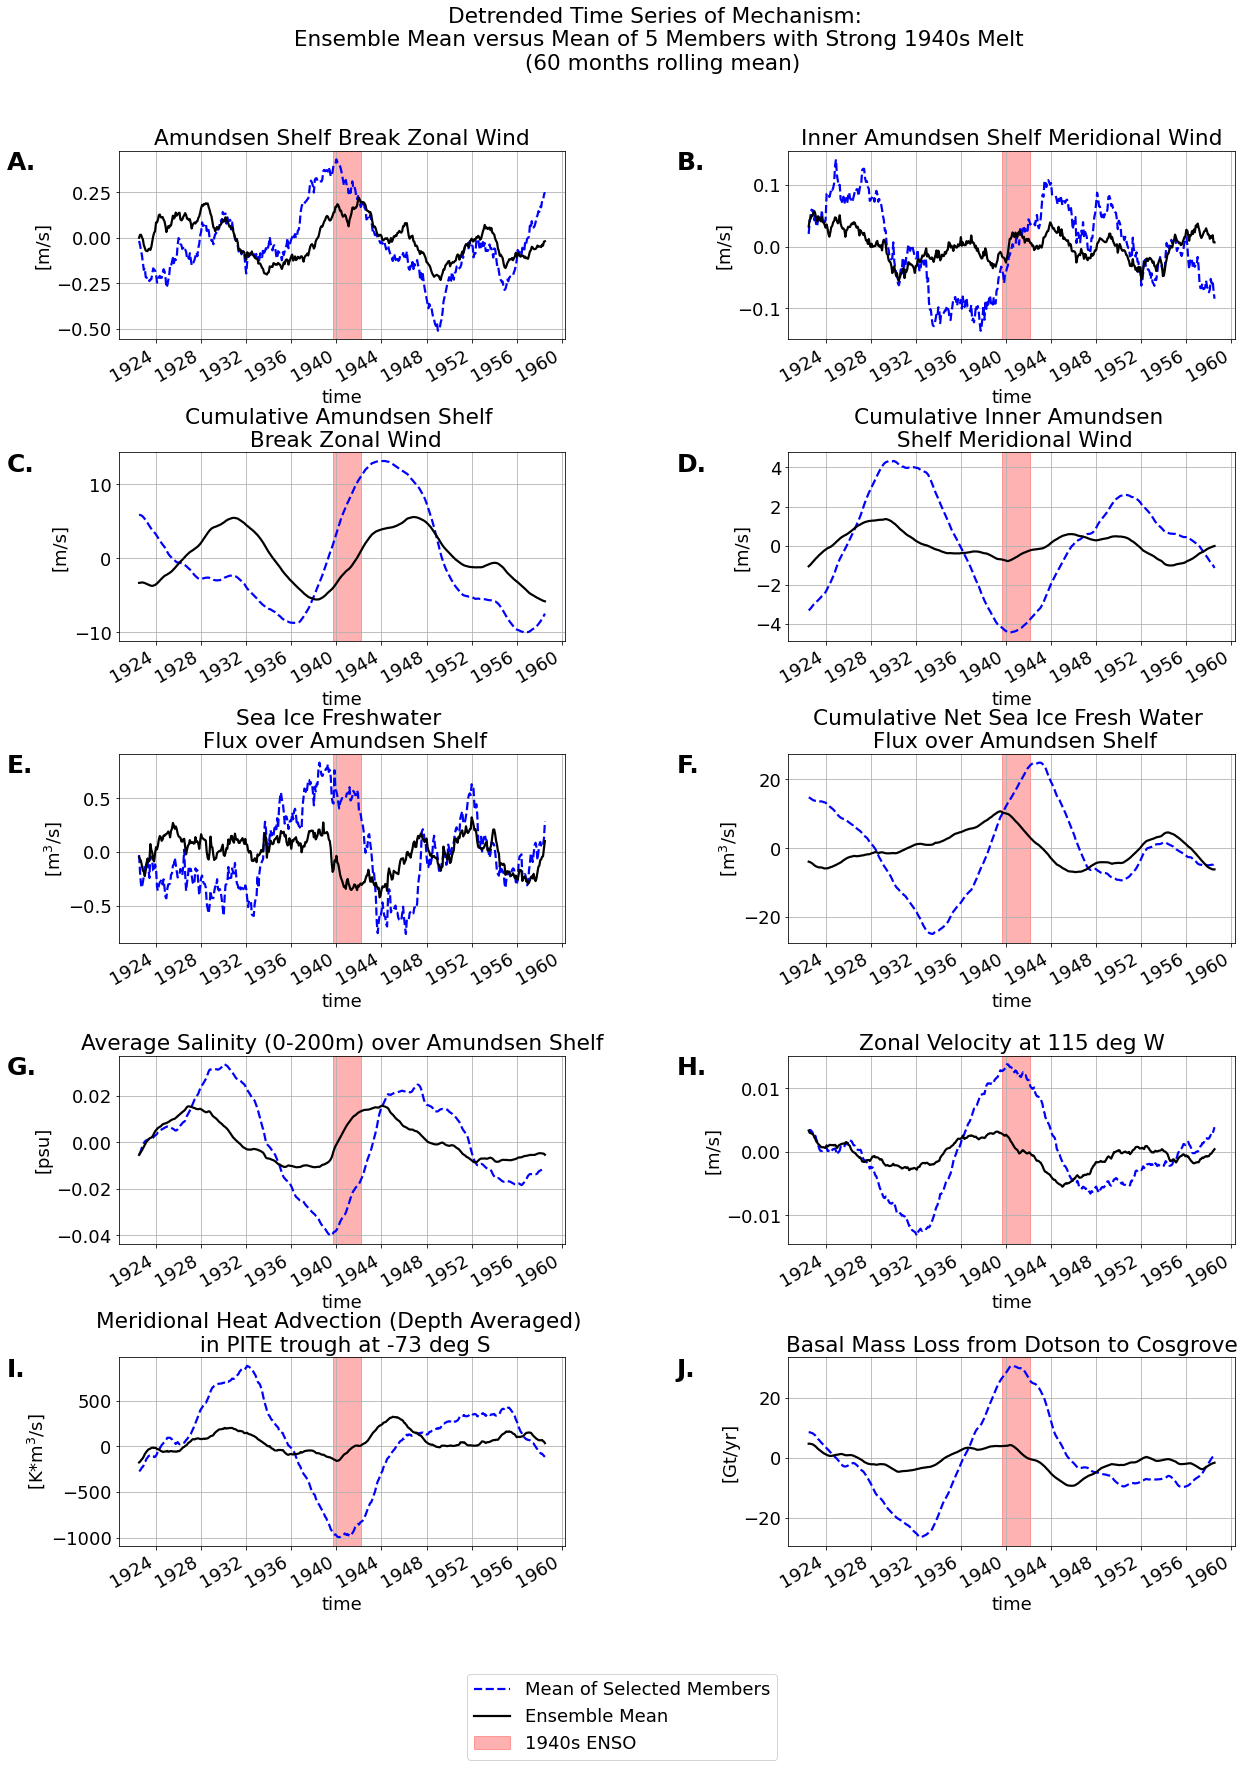

In [16]:
#What happens during strong 1940s?
#In this plot we show member detrended members

window=60 #Window for running mean

#Which way to select high melt members?
#Option1
# a=melt.sel(time=slice('1940', '1941')).mean(dim='time')\
# -melt.sel(time=slice('1938', '1939')).mean(dim='time')
# handpicked=np.asarray(a.ens.sortby(a)[-5:])

# #Option2
# a=melt_dt.sel(time=slice('1940', '1941')).mean(dim='time')\
# -melt_dt.sel(time=slice('1938', '1939')).mean(dim='time')
# handpicked=np.asarray(a.ens.sortby(a)[-5:])

# #Option3
a=melt_dt.sel(time=slice('1940', '1941')).mean(dim='time')
handpicked=np.asarray(a.ens.sortby(a)[-5:])

# #Option4
# a=melt.sel(time=slice('1940', '1941')).mean(dim='time')
# handpicked=np.asarray(a.ens.sortby(a)[-5:])


    
fig=plt.figure(plt.figure(figsize=(20,25)))
fig.suptitle('Detrended Time Series of Mechanism: \n Ensemble Mean versus Mean of 5 Members with Strong 1940s Melt \n ({} months rolling mean)'.format(str(window)))
ax=plt.subplot(5,2,1)
plot_timeseries(data=uwind_dt, ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[m/s]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Amundsen Shelf Break Zonal Wind')

ax=plt.subplot(5,2,2)
plot_timeseries(data=vwind_dt, ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[m/s]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Inner Amundsen Shelf Meridional Wind')

ax=plt.subplot(5,2,3)
plot_timeseries(data=cumul_uwind_dt, ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[m/s]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Cumulative Amundsen Shelf \n Break Zonal Wind')

ax=plt.subplot(5,2,4)
plot_timeseries(data=cumul_vwind_dt, ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[m/s]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Cumulative Inner Amundsen \n Shelf Meridional Wind')

# ax=plt.subplot(2,3,5)
# plot_timeseries(data=vwind['pine_island_bay_vwind_avg'], ax=ax, 
#                 window=window, handpicked=handpicked, years=[1920,1950], show40s=True,
#                 colors=['grey','yellow','blue','red'], 
#                 label='Average Meridional Wind over \n Inner Amundsen Shelf [psu]')


ax=plt.subplot(5,2,5)
plot_timeseries(data=seaice_dt, ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[m$^3$/s]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Sea Ice Freshwater \n Flux over Amundsen Shelf')

ax=plt.subplot(5,2,6)
plot_timeseries(data=cumul_seaice_dt, ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[m$^3$/s]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Cumulative Net Sea Ice Fresh Water \n Flux over Amundsen Shelf')

# ax=plt.subplot(2,3,4)
# plot_timeseries(data=salt['amundsen_shelf_salt_below_0m'], ax=ax, 
#                 window=60, handpicked=None, years=[1920,2013], show40s=True,
#                 colors=['grey','black','blue','red'], 
#                 label='Average Salinity over \n Continental Shelf [psu]')

# ax=plt.subplot(3,2,4)
# plot_timeseries(data=salt['amundsen_shelf_salt_btw_0_200m'], ax=ax, 
#                 window=window, handpicked=handpicked, years=[1920,2013], show40s=True,
#                 colors=['grey','black','blue','black'], 
#                 label='Average Salinity (0-200m) over \n Continental Shelf [psu]', show=[False, True, False, True])


ax=plt.subplot(5,2,7)
plot_timeseries(data=salt_dt, ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[psu]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Average Salinity (0-200m) over Amundsen Shelf')

ax=plt.subplot(5,2,8)
plot_timeseries(data=U115_dt, ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[m/s]', show=[False, True, False, True])
ax.set_title('Zonal Velocity at 115 deg W')
ax.get_legend().remove()

ax=plt.subplot(5,2,9)
plot_timeseries(data=PITE_dt, ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[K*m$^3$/s]', show=[False, True, False, True])
ax.set_title('Meridional Heat Advection (Depth Averaged) \n in PITE trough at -73 deg S')
ax.get_legend().remove()

ax=plt.subplot(5,2,10)
plot_timeseries(data=melt_dt, ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[Gt/yr]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Basal Mass Loss from Dotson to Cosgrove')

fig.subplots_adjust(hspace=0.6, wspace=0.5, top=0.9)
fig.legend(['Mean of Selected Members', 'Ensemble Mean', '1940s ENSO'], loc='lower center')

import string
for n, ax in enumerate(fig.axes):
        ax.text(-0.25, 0.9, string.ascii_uppercase[n]+'.', transform=ax.transAxes, 
            size=25, weight='bold')

fig.savefig('../03_output/timeseries/mechanism_1940s_{}months_zoomed_dt.png'.format(str(window)))

## Without Convection: select only members that do not show convection and do the same trick

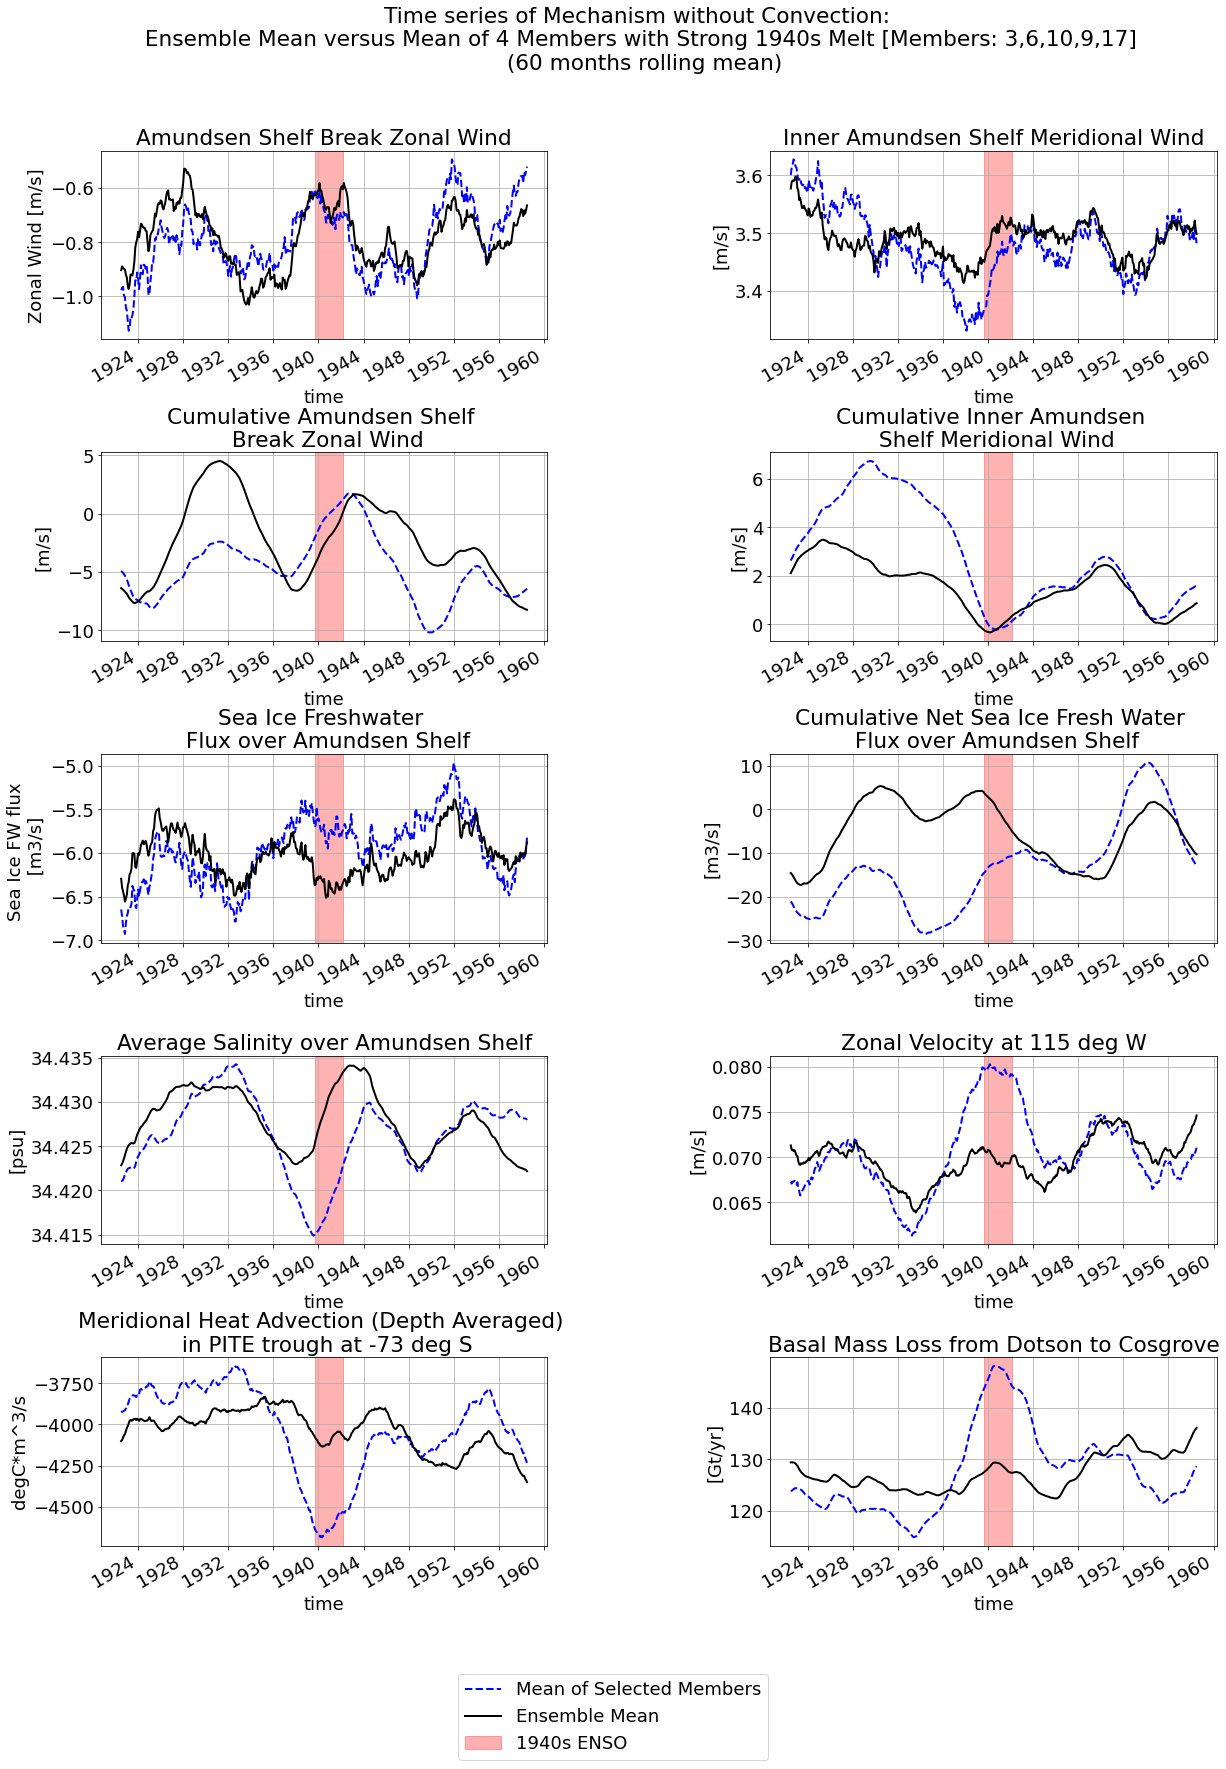

In [28]:
convmem=[2,  3,  4,  7,  8,  9, 13, 15, 18, 19] #Members that do not show convection in the ime interval

#What happens during strong 1940s?
#Here, we use absolute time series

window=60
#Option1
# a=melt.sel(time=slice('1940', '1941')).mean(dim='time')\
# -melt.sel(time=slice('1938', '1939')).mean(dim='time')
# handpicked=np.asarray(a.ens.sortby(a)[-5:])

# #Option2
# a=melt_dt.sel(ens=convmem).sel(time=slice('1940', '1941')).mean(dim='time')\
# -melt_dt.sel(ens=convmem).sel(time=slice('1938', '1939')).mean(dim='time')
# handpicked=np.asarray(a.ens.sortby(a)[-5:])

# #Option3
a=melt_dt.sel(ens=convmem).sel(time=slice('1940', '1941')).mean(dim='time')
handpicked=np.asarray(a.ens.sortby(a)[-5:])

# #Option4
# a=melt.sel(time=slice('1940', '1941')).mean(dim='time')
# handpicked=np.asarray(a.ens.sortby(a)[-5:])

#handpicked=[2,5,9,8,16]
#handpicked=[16,9,2,5,7]
#handpicked=[16,0,12,9, 5]

fig=plt.figure(plt.figure(figsize=(20,25)))
fig.suptitle('Time series of Mechanism without Convection: \n Ensemble Mean versus Mean of 4 Members with Strong 1940s Melt [Members: 3,6,10,9,17] \n ({} months rolling mean)'.format(str(window)))
ax=plt.subplot(5,2,1)
plot_timeseries(data=full['amundsen_shelf_break_uwind_avg'].sel(ens=convmem), ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='Zonal Wind [m/s]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Amundsen Shelf Break Zonal Wind')

ax=plt.subplot(5,2,2)
plot_timeseries(data=vwind['inner_amundsen_shelf_vwind_avg'].sel(ens=convmem), ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[m/s]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Inner Amundsen Shelf Meridional Wind')

ax=plt.subplot(5,2,3)
plot_timeseries(data=cumul_uwind.sel(ens=convmem), ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[m/s]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Cumulative Amundsen Shelf \n Break Zonal Wind')

ax=plt.subplot(5,2,4)
plot_timeseries(data=cumul_vwind.sel(ens=convmem), ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[m/s]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Cumulative Inner Amundsen \n Shelf Meridional Wind')

ax=plt.subplot(5,2,5)
plot_timeseries(data=forcing['amundsen_shelf_seaice_freeze'].sel(ens=convmem)+forcing['amundsen_shelf_seaice_melt'].sel(ens=convmem), ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='Sea Ice FW flux \n [m3/s]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Sea Ice Freshwater \n Flux over Amundsen Shelf')

ax=plt.subplot(5,2,6)
plot_timeseries(data=cumul_seaice.sel(ens=convmem), ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[m3/s]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Cumulative Net Sea Ice Fresh Water \n Flux over Amundsen Shelf')

ax=plt.subplot(5,2,7)
plot_timeseries(data=salt2['amundsen_shelf_salt_below_0m'].sel(ens=convmem), ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[psu]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Average Salinity over Amundsen Shelf')

ax=plt.subplot(5,2,8)
plot_timeseries(data=U115.sel(ens=convmem), ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[m/s]', show=[False, True, False, True])
ax.set_title('Zonal Velocity at 115 deg W')
ax.get_legend().remove()

ax=plt.subplot(5,2,9)
plot_timeseries(data=PITE.sel(ens=convmem), ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='degC*m^3/s', show=[False, True, False, True])
ax.set_title('Meridional Heat Advection (Depth Averaged) \n in PITE trough at -73 deg S')
ax.get_legend().remove()

ax=plt.subplot(5,2,10)
plot_timeseries(data=full['dotson_to_cosgrove_massloss'].sel(ens=convmem), ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[Gt/yr]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Basal Mass Loss from Dotson to Cosgrove')

fig.subplots_adjust(hspace=0.6, wspace=0.5, top=0.9)
fig.legend(['Mean of Selected Members', 'Ensemble Mean', '1940s ENSO'], loc='lower center')

#fig.savefig('../03_output/timeseries/Mechanism_1940s_{}months_zoomed.png'.format(str(window)))

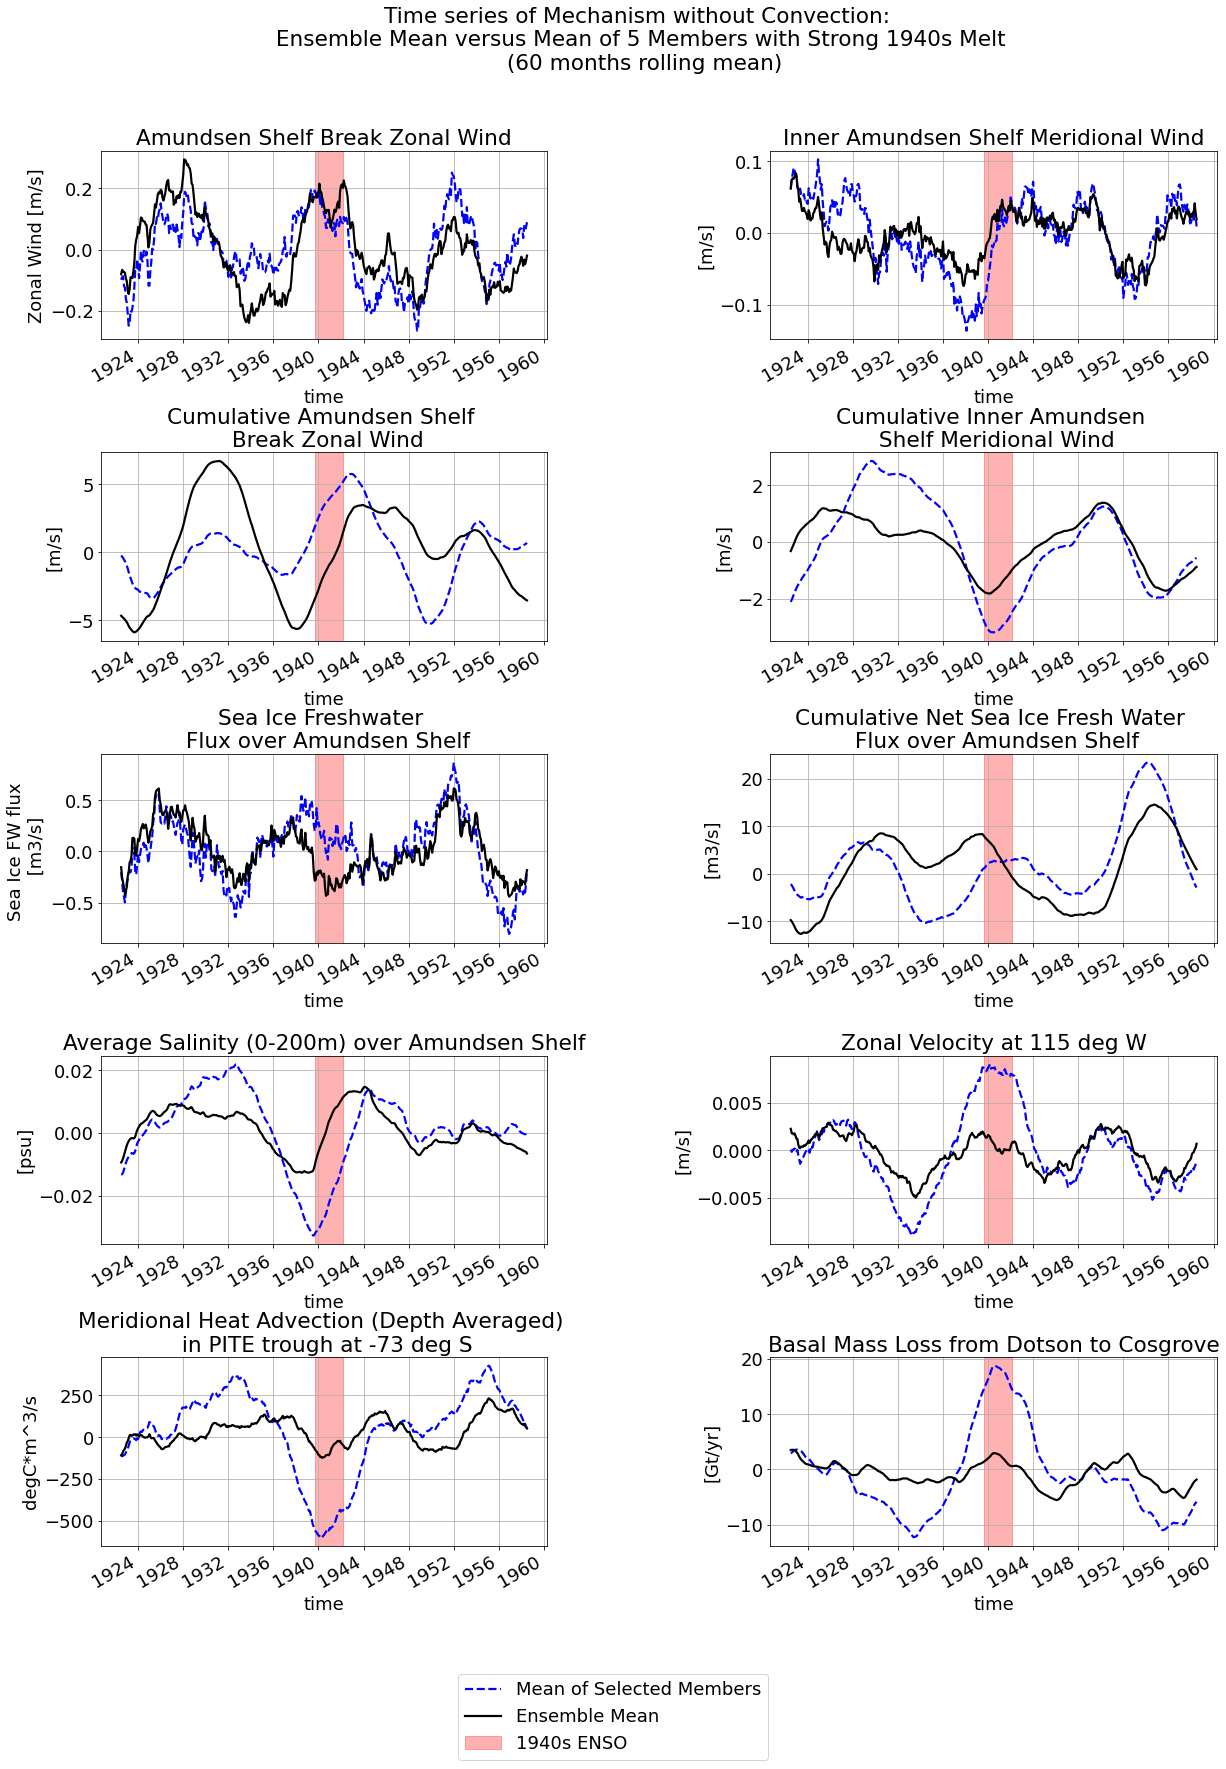

In [17]:
#What happens during strong 1940s?
convmem=[2,  3,  4,  7,  8,  9, 13, 15, 18, 19] #Members without convection


window=60
#Here, we use detrended time series

#Option1
# a=melt.sel(time=slice('1940', '1941')).mean(dim='time')\
# -melt.sel(time=slice('1938', '1939')).mean(dim='time')
# handpicked=np.asarray(a.ens.sortby(a)[-5:])

# #Option2
#a=melt_dt.sel(ens=convmem).sel(time=slice('1940', '1941')).mean(dim='time')\
#-melt_dt.sel(ens=convmem).sel(time=slice('1938', '1939')).mean(dim='time')
#handpicked=np.asarray(a.ens.sortby(a)[-5:])

# #Option3
a=melt_dt.sel(ens=convmem).sel(time=slice('1940', '1941')).mean(dim='time')
handpicked=np.asarray(a.ens.sortby(a)[-5:])

# #Option4
# a=melt.sel(time=slice('1940', '1941')).mean(dim='time')
# handpicked=np.asarray(a.ens.sortby(a)[-5:])

                                         
fig=plt.figure(plt.figure(figsize=(20,25)))
fig.suptitle('Time series of Mechanism without Convection: \n Ensemble Mean versus Mean of 5 Members with Strong 1940s Melt \n ({} months rolling mean)'.format(str(window)))
ax=plt.subplot(5,2,1)
plot_timeseries(data=uwind_dt.sel(ens=convmem), ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='Zonal Wind [m/s]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Amundsen Shelf Break Zonal Wind')

ax=plt.subplot(5,2,2)
plot_timeseries(data=vwind_dt.sel(ens=convmem), ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[m/s]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Inner Amundsen Shelf Meridional Wind')

ax=plt.subplot(5,2,3)
plot_timeseries(data=cumul_uwind_dt.sel(ens=convmem), ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[m/s]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Cumulative Amundsen Shelf \n Break Zonal Wind')

ax=plt.subplot(5,2,4)
plot_timeseries(data=cumul_vwind_dt.sel(ens=convmem), ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[m/s]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Cumulative Inner Amundsen \n Shelf Meridional Wind')

# ax=plt.subplot(2,3,5)
# plot_timeseries(data=vwind['pine_island_bay_vwind_avg'], ax=ax, 
#                 window=window, handpicked=handpicked, years=[1920,1950], show40s=True,
#                 colors=['grey','yellow','blue','red'], 
#                 label='Average Meridional Wind over \n Inner Amundsen Shelf [psu]')


ax=plt.subplot(5,2,5)
plot_timeseries(data=seaice_dt.sel(ens=convmem), ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='Sea Ice FW flux \n [m3/s]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Sea Ice Freshwater \n Flux over Amundsen Shelf')

ax=plt.subplot(5,2,6)
plot_timeseries(data=cumul_seaice_dt.sel(ens=convmem), ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[m3/s]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Cumulative Net Sea Ice Fresh Water \n Flux over Amundsen Shelf')

# ax=plt.subplot(2,3,4)
# plot_timeseries(data=salt['amundsen_shelf_salt_below_0m'], ax=ax, 
#                 window=60, handpicked=None, years=[1920,2013], show40s=True,
#                 colors=['grey','black','blue','red'], 
#                 label='Average Salinity over \n Continental Shelf [psu]')

# ax=plt.subplot(3,2,4)
# plot_timeseries(data=salt['amundsen_shelf_salt_btw_0_200m'], ax=ax, 
#                 window=window, handpicked=handpicked, years=[1920,2013], show40s=True,
#                 colors=['grey','black','blue','black'], 
#                 label='Average Salinity (0-200m) over \n Continental Shelf [psu]', show=[False, True, False, True])


ax=plt.subplot(5,2,7)
plot_timeseries(data=salt_dt.sel(ens=convmem), ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[psu]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Average Salinity (0-200m) over Amundsen Shelf')

ax=plt.subplot(5,2,8)
plot_timeseries(data=U115_dt.sel(ens=convmem), ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[m/s]', show=[False, True, False, True])
ax.set_title('Zonal Velocity at 115 deg W')
ax.get_legend().remove()

ax=plt.subplot(5,2,9)
plot_timeseries(data=PITE_dt.sel(ens=convmem), ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='degC*m^3/s', show=[False, True, False, True])
ax.set_title('Meridional Heat Advection (Depth Averaged) \n in PITE trough at -73 deg S')
ax.get_legend().remove()

ax=plt.subplot(5,2,10)
plot_timeseries(data=melt_dt.sel(ens=convmem), ax=ax, 
                window=window, handpicked=handpicked, years=[1920,1960], show40s=True,
                colors=['grey','black','blue','blue'], 
                label='[Gt/yr]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Basal Mass Loss from Dotson to Cosgrove')

fig.subplots_adjust(hspace=0.6, wspace=0.5, top=0.9)
fig.legend(['Mean of Selected Members', 'Ensemble Mean', '1940s ENSO'], loc='lower center')

fig.savefig('../03_output/timeseries/mechanism_1940s_{}months_zoomed_dt_wo_convection.png'.format(str(window)))

#### What happened in the 1990s?

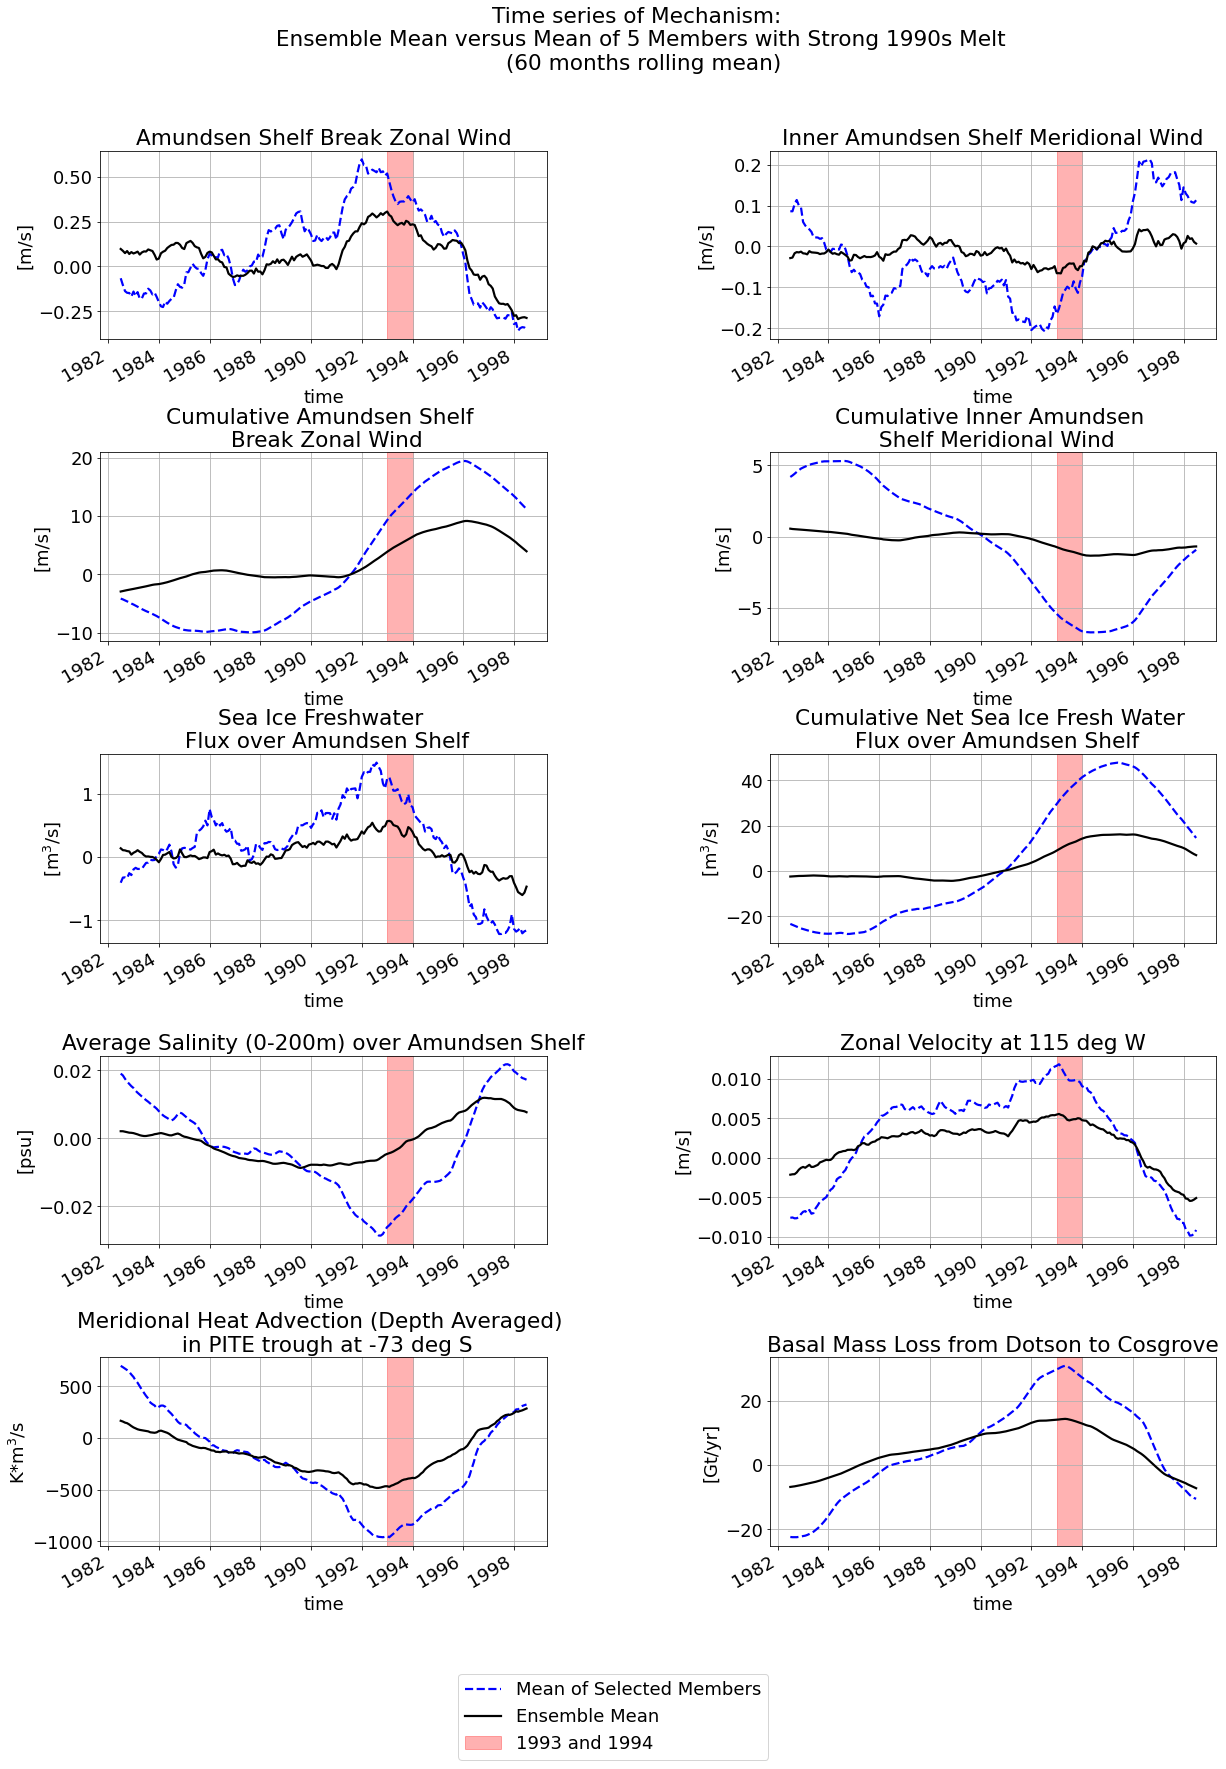

In [19]:
#What happens during strong 1990s?
window=60
#Option1
# a=melt.sel(time=slice('1940', '1941')).mean(dim='time')\
# -melt.sel(time=slice('1938', '1939')).mean(dim='time')
# handpicked=np.asarray(a.ens.sortby(a)[-5:])

# #Option2
# a=melt_dt.sel(time=slice('1940', '1941')).mean(dim='time')\
# -melt_dt.sel(time=slice('1938', '1939')).mean(dim='time')
# handpicked=np.asarray(a.ens.sortby(a)[-5:])

# #Option3
a=melt_dt.sel(time=slice('1993', '1994')).mean(dim='time') #Based on anomaly in 1993-1994
handpicked=np.asarray(a.ens.sortby(a)[-5:])

# #Option4
# a=melt.sel(time=slice('1940', '1941')).mean(dim='time')
# handpicked=np.asarray(a.ens.sortby(a)[-5:])

                                         
fig=plt.figure(plt.figure(figsize=(20,25)))
fig.suptitle('Time series of Mechanism: \n Ensemble Mean versus Mean of 5 Members with Strong 1990s Melt \n ({} months rolling mean)'.format(str(window)))
ax=plt.subplot(5,2,1)
plot_timeseries(data=uwind_dt, ax=ax, 
                window=window, handpicked=handpicked, years=[1980,2000], show40s=False,show90s=True,
                colors=['grey','black','blue','blue'], 
                label='[m/s]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Amundsen Shelf Break Zonal Wind')

ax=plt.subplot(5,2,2)
plot_timeseries(data=vwind_dt, ax=ax, 
                window=window, handpicked=handpicked, years=[1980,2000], show40s=False,show90s=True,
                colors=['grey','black','blue','blue'], 
                label='[m/s]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Inner Amundsen Shelf Meridional Wind')

ax=plt.subplot(5,2,3)
plot_timeseries(data=cumul_uwind_dt, ax=ax, 
                window=window, handpicked=handpicked, years=[1980,2000], show40s=False,show90s=True,
                colors=['grey','black','blue','blue'], 
                label='[m/s]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Cumulative Amundsen Shelf \n Break Zonal Wind')

ax=plt.subplot(5,2,4)
plot_timeseries(data=cumul_vwind_dt, ax=ax, 
                window=window, handpicked=handpicked, years=[1980,2000], show40s=False,show90s=True,
                colors=['grey','black','blue','blue'], 
                label='[m/s]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Cumulative Inner Amundsen \n Shelf Meridional Wind')

# ax=plt.subplot(2,3,5)
# plot_timeseries(data=vwind['pine_island_bay_vwind_avg'], ax=ax, 
#                 window=window, handpicked=handpicked, years=[1920,1950], show40s=True,
#                 colors=['grey','yellow','blue','red'], 
#                 label='Average Meridional Wind over \n Inner Amundsen Shelf [psu]')


ax=plt.subplot(5,2,5)
plot_timeseries(data=seaice_dt, ax=ax, 
                window=window, handpicked=handpicked, years=[1980,2000], show40s=False,show90s=True,
                colors=['grey','black','blue','blue'], 
                label='[m$^3$/s]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Sea Ice Freshwater \n Flux over Amundsen Shelf')

ax=plt.subplot(5,2,6)
plot_timeseries(data=cumul_seaice_dt, ax=ax, 
                window=window, handpicked=handpicked, years=[1980,2000], show40s=False,show90s=True,
                colors=['grey','black','blue','blue'], 
                label='[m$^3$/s]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Cumulative Net Sea Ice Fresh Water \n Flux over Amundsen Shelf')

# ax=plt.subplot(2,3,4)
# plot_timeseries(data=salt['amundsen_shelf_salt_below_0m'], ax=ax, 
#                 window=60, handpicked=None, years=[1920,2013], show40s=True,
#                 colors=['grey','black','blue','red'], 
#                 label='Average Salinity over \n Continental Shelf [psu]')

# ax=plt.subplot(3,2,4)
# plot_timeseries(data=salt['amundsen_shelf_salt_btw_0_200m'], ax=ax, 
#                 window=window, handpicked=handpicked, years=[1920,2013], show40s=True,
#                 colors=['grey','black','blue','black'], 
#                 label='Average Salinity (0-200m) over \n Continental Shelf [psu]', show=[False, True, False, True])


ax=plt.subplot(5,2,7)
plot_timeseries(data=salt_dt, ax=ax, 
                window=window, handpicked=handpicked, years=[1980,2000], show40s=False,show90s=True,
                colors=['grey','black','blue','blue'], 
                label='[psu]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Average Salinity (0-200m) over Amundsen Shelf')

ax=plt.subplot(5,2,8)
plot_timeseries(data=U115_dt, ax=ax, 
                window=window, handpicked=handpicked, years=[1980,2000], show40s=False, show90s=True,
                colors=['grey','black','blue','blue'], 
                label='[m/s]', show=[False, True, False, True])
ax.set_title('Zonal Velocity at 115 deg W')
ax.get_legend().remove()

ax=plt.subplot(5,2,9)
plot_timeseries(data=PITE_dt, ax=ax, 
                window=window, handpicked=handpicked, years=[1980,2000], show40s=False,show90s=True,
                colors=['grey','black','blue','blue'], 
                label='K*m$^3$/s', show=[False, True, False, True])
ax.set_title('Meridional Heat Advection (Depth Averaged) \n in PITE trough at -73 deg S')
ax.get_legend().remove()

ax=plt.subplot(5,2,10)
plot_timeseries(data=melt_dt, ax=ax, 
                window=window, handpicked=handpicked, years=[1980,2000], show40s=False,show90s=True,
                colors=['grey','black','blue','blue'], 
                label='[Gt/yr]', show=[False, True, False, True])
ax.get_legend().remove()
ax.set_title('Basal Mass Loss from Dotson to Cosgrove')

fig.subplots_adjust(hspace=0.6, wspace=0.5, top=0.9)
fig.legend(['Mean of Selected Members', 'Ensemble Mean', '1993 and 1994'], loc='lower center')

fig.savefig('../03_output/timeseries/mechanism_1990s_{}months_zoomed_dt.png'.format(str(window)))